In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns

In [2]:
#load data from pkl files
def data_load(code = 0):
    return pd.read_pickle('event_'+str(code)+'_data.pkl')
#load data from all dataset
data_modified = pd.read_csv('dataset_modified.csv')

In [3]:
features_time       = np.array(['begin','end','event'])
features_sensor     = data_modified['type'].unique()
features_sensor.sort()
features = np.concatenate([features_sensor,features_time],axis=0)
train_input = pd.DataFrame(columns = features)
train_input

,AD1-A,AD1-B,AD1-C,D03,D05,D07,D08,D09,D10,D12,...,M45,M46,M47,M48,M49,M50,M51,begin,end,event


In [4]:
#each day each activity
def train_data_prepare(mat,code = 0):
    data = data_load(code)
    #event list
    begin_point = data['BE'].str.contains('begin').fillna(False)
    end_point   = data['BE'].str.contains('end').fillna(False)

    index_begin         = data.loc[begin_point].index
    index_end           = data.loc[end_point].index
    only_event_begin    = data.loc[index_begin]
    only_event_end      = data.loc[index_end]

    event_begin         = only_event_begin.loc[data['location'].str.contains(data.head(1)['location'].values[0]).fillna(False)]
    event_end           = only_event_end.loc[data['location'].str.contains(data.head(1)['location'].values[0]).fillna(False)]

    for i in range(len(event_begin)):
        #single event sensor data
        sensor_event            = data.loc[event_begin.index[i]:event_end.index[i]]
        sensor_event_count      = sensor_event['type'].value_counts()
        sensor_values           = sensor_event_count.sort_values()
        sensor_sum              = sensor_values.sum()
        sensor_values           = sensor_values/sensor_sum

        #single event time data
        hour_begin  = int(event_begin['time'].values[i][0:2])
        hour_end    = int(event_end['time'].values[i][0:2])

        #put observation into matrix
        sensor_values = pd.concat([sensor_values,pd.Series([hour_begin/24,hour_end/24,str(code)],index = ['begin','end','event'])])
        single_obs = pd.DataFrame(sensor_values).transpose()
        mat = pd.concat((mat,single_obs),axis=0)
        pass

    mat = mat.fillna(0)
    mat = mat.reset_index(drop=True)
    return mat

In [5]:
train = []
for i in range(13):
    print(i)
    mat = train_data_prepare(train_input,i)
    train.append(mat)
    pass

0
1
2
3
4
5
6
7
8
9
10
11
12


In [192]:
train_df = pd.concat(train)
train_df = train_df.reset_index(drop=True)
train_df.head(1)

,AD1-A,AD1-B,AD1-C,D03,D05,D07,D08,D09,D10,D12,...,M45,M46,M47,M48,M49,M50,M51,begin,end,event
0,0.027778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.291667,0.291667,0


In [7]:
X = train_df.drop('event',1)
y = train_df['event']

C:\Users\karl_\AppData\Local\Temp/ipykernel_2480/3655079518.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = train_df.drop('event',1)


In [8]:
def seperate_y(y):
    y_all = []
    for i in range(13):
        code = i

        code_list = ['0','1','2','3','4','5','6','7','8','9','10','11','12']
        code_list.remove(str(code))
        y_temp = y.replace(code_list,'NO')
        y_temp = y_temp.replace([str(code)],'YES')
        y_all.append(y_temp)
        pass
    return y_all

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=5)

In [11]:
rf = RandomForestClassifier(n_estimators=300,max_features=None)
rf.fit(X_train,y_train)
print(rf.score(X_train,y_train))
print(rf.score(X_test,y_test))

0.9975609756097561
0.8543689320388349


In [12]:
clf = MLPClassifier(max_iter=10000,hidden_layer_sizes = (148,39))
clf.fit(X_train,y_train)
print(rf.score(X_train,y_train))
print(rf.score(X_test,y_test))

0.9975609756097561
0.8543689320388349


In [18]:
Y_train = []
Y_test  = []
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=5)

Y_train = seperate_y(y_train)
Y_test  = seperate_y(y_test)

importance = []

rf_proba_train  = []
rf_proba_test   = []
acc_train       = []
acc_test        = []
rf = RandomForestClassifier(n_estimators=300,max_features=None)
for code in range(13):
    rf.fit(X_train,Y_train[code])
    
    importance.append(rf.feature_importances_)

    y_train_pred    = rf.predict(X_train)
    y_test_pred     = rf.predict(X_test)

    temp_train  = pd.Series(y_train_pred.tolist())
    temp_train  = temp_train.replace('NO',-1)
    temp_train  = temp_train.replace('YES',str(code))
    temp_test   = pd.Series(y_test_pred.tolist())
    temp_test   = temp_test.replace('NO',-1)
    temp_test   = temp_test.replace('YES',str(code))

    acc_train.append(accuracy_score(Y_train[code],y_train_pred))
    acc_test.append(accuracy_score(Y_test[code],y_test_pred))

    rf_proba_train.append(temp_train)
    rf_proba_test.append(temp_test)
    pass

In [193]:
#weight the dataset using feature importance
train_df_adjust = train_df.copy()
train_df_adjust

,AD1-A,AD1-B,AD1-C,D03,D05,D07,D08,D09,D10,D12,...,M45,M46,M47,M48,M49,M50,M51,begin,end,event
0,0.027778,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.291667,0.291667,0
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.291667,0.291667,0
2,0.105634,0.133803,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.042254,0.291667,0.291667,0
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.250000,0.291667,0
4,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.291667,0.291667,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.791667,0.916667,12
509,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.791667,0.916667,12
510,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.833333,0.916667,12
511,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.333333,0.333333,12


In [202]:
for i in range(13):
    # filter the feature give 0 weight to feature whose importance is below threshold
    filter_threshold = 1.1
    skip_threshold = 0.3
    code = i
    importance_modify = (pd.Series(importance[code])+1).transpose()
    importance_modify[importance_modify<filter_threshold] = skip_threshold

    # make the new dataframe
    temp = train_df_adjust.loc[train_df_adjust['event']==str(code)]
    temp.iloc[:,0:73] = temp.iloc[:,0:73].mul(importance_modify.values,axis=1)
    train_df_adjust.loc[train_df_adjust['event']==str(code)] = temp
    pass

C:\Users\karl_\AppData\Local\Temp/ipykernel_2480/4118451189.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.iloc[:,0:73] = temp.iloc[:,0:73].mul(importance_modify.values,axis=1)


In [199]:
train_df_adjust

,AD1-A,AD1-B,AD1-C,D03,D05,D07,D08,D09,D10,D12,...,M45,M46,M47,M48,M49,M50,M51,begin,end,event
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12
509,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12
510,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12
511,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12


In [201]:
train_df_adjust.to_csv('train_adjust.csv')

In [200]:
X = train_df_adjust.drop('event',1)
y = train_df_adjust['event']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=5)
rf = RandomForestClassifier(n_estimators=300,max_features=None)
rf.fit(X_train,y_train)
print(rf.score(X_train,y_train))
print(rf.score(X_test,y_test))

C:\Users\karl_\AppData\Local\Temp/ipykernel_2480/161743721.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = train_df_adjust.drop('event',1)


0.9926829268292683
0.9902912621359223


<AxesSubplot:>

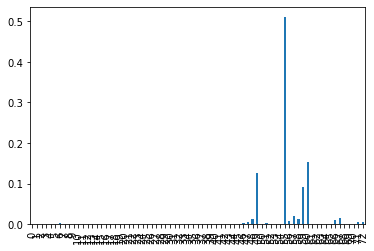

In [25]:
feature_names = range(73)
forest_importances = pd.Series(importance[0], index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)

In [14]:
rf_p = []
for i in range(13):
    temp = pd.Series(rf_proba_test[i])
    rf_p.append(temp)
    pass

In [15]:
final_pred = []
for i in range(len(rf_p[0])):
    temp = []
    prob = []
    for j in range(len(rf_p)):
        if rf_p[j][i] != -1:
            temp.append(rf_p[j][i])
            prob.append(acc_test[j])
            pass
        pass
    if prob: 
        final_pred.append(temp[prob.index(max(prob))])
    else:
        final_pred.append(-1)
    pass
    

In [16]:
y_sep_predict   = pd.Series(final_pred)
y_sep_predict   = y_sep_predict.astype('int')
y_sep_test      = y_test.astype('int')

In [17]:
accuracy_score(y_sep_test,y_sep_predict)

0.7864077669902912